#### Подключение библиотек и скриптов

In [1]:
import numpy as np
import pandas as pd
import random

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import BaggingRegressor

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import r2_score as r2
from sklearn.model_selection import KFold, GridSearchCV

from datetime import datetime

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
matplotlib.rcParams.update({'font.size': 14})

In [4]:
def evaluate_preds(train_true_values, train_pred_values, test_true_values, test_pred_values):
    print("Train R2:\t" + str(round(r2(train_true_values, train_pred_values), 3)))
    print("Test R2:\t" + str(round(r2(test_true_values, test_pred_values), 3)))
    
    plt.figure(figsize=(18,10))
    
    plt.subplot(121)
    sns.scatterplot(x=train_pred_values, y=train_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Train sample prediction')
    
    plt.subplot(122)
    sns.scatterplot(x=test_pred_values, y=test_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Test sample prediction')

    plt.show()

#### Пути к директориям и файлам

In [5]:
TRAIN_DATASET_PATH = 'train.csv'
TEST_DATASET_PATH = 'test.csv'

#### Загрузка данных

#### Описание датасета

- Id - идентификационный номер квартиры
- DistrictId - идентификационный номер района
- Rooms - количество комнат
- Square - площадь
- LifeSquare - жилая площадь
- KitchenSquare - площадь кухни
- Floor - этаж
- HouseFloor - количество этажей в доме
- HouseYear - год постройки дома
- Ecology_1, Ecology_2, Ecology_3 - экологические показатели местности
- Social_1, Social_2, Social_3 - социальные показатели местности
- Healthcare_1, Helthcare_2 - показатели местности, связанные с охраной здоровья
- Shops_1, Shops_2 - показатели, связанные с наличием магазинов, торговых центров
- Price - цена квартиры

In [6]:
train_df = pd.read_csv(TRAIN_DATASET_PATH)
train_df.tail()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
9995,1260,61,2.0,49.090728,33.272626,6.0,3,12.0,1981,0.300323,B,B,52,10311,6,NaN,1,9,B,119367.455796
9996,16265,27,2.0,64.307684,37.038420,9.0,13,0.0,1977,0.072158,B,B,2,629,1,NaN,0,0,A,199715.148807
9997,2795,178,1.0,29.648057,16.555363,5.0,3,5.0,1958,0.460556,B,B,20,4386,14,NaN,1,5,B,165953.912580
9998,14561,21,1.0,32.330292,22.326870,5.0,3,9.0,1969,0.194489,B,B,47,8004,3,125.0,3,5,B,171842.411855
9999,7202,94,1.0,35.815476,22.301367,6.0,9,9.0,1975,0.127376,B,B,43,8429,3,NaN,3,9,B,177685.627486


In [7]:
train_df.dtypes

Id                 int64
DistrictId         int64
Rooms            float64
Square           float64
LifeSquare       float64
KitchenSquare    float64
Floor              int64
HouseFloor       float64
HouseYear          int64
Ecology_1        float64
Ecology_2         object
Ecology_3         object
Social_1           int64
Social_2           int64
Social_3           int64
Healthcare_1     float64
Helthcare_2        int64
Shops_1            int64
Shops_2           object
Price            float64
dtype: object

In [8]:
test_df = pd.read_csv(TEST_DATASET_PATH)
test_df.tail()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
4995,10379,29,2.0,43.177521,30.339945,5.0,6,5.0,1962,0.069660,B,B,31,6119,4,NaN,1,2,B
4996,16138,38,3.0,93.698122,94.521465,10.0,21,27.0,2018,0.060753,B,B,15,2787,2,520.0,0,7,B
4997,3912,101,1.0,33.656723,19.003259,5.0,2,5.0,1966,0.038693,B,B,28,6533,1,1015.0,2,5,B
4998,5722,10,1.0,38.635155,20.976257,9.0,8,14.0,1970,0.089040,B,B,33,7976,5,NaN,0,11,B
4999,11004,21,2.0,67.122742,33.944344,13.0,9,17.0,2009,0.194489,B,B,47,8004,3,125.0,3,5,B


In [9]:
train_df.shape[1] - 1 == test_df.shape[1]

True

#### Приведение типов

In [10]:
train_df['Id'] = train_df['Id'].astype(str)
train_df['DistrictId'] = train_df['DistrictId'].astype(str)

### 1. EDA
Делаем EDA для:

- Исправления выбросов
- Заполнения NaN
- Идей для генерации новых фич

#### Целевая переменная

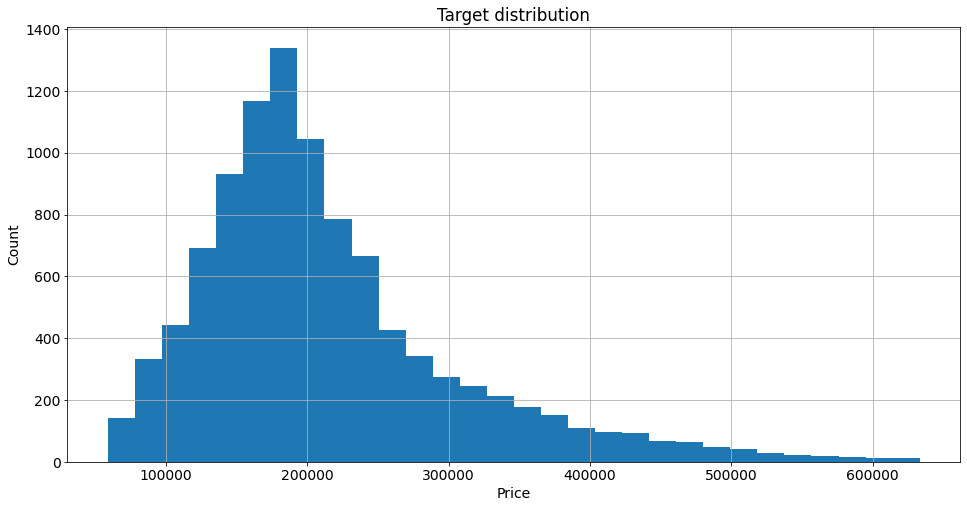

In [11]:
plt.figure(figsize = (16, 8))

train_df['Price'].hist(bins=30)
plt.ylabel('Count')
plt.xlabel('Price')

plt.title('Target distribution')
plt.show()

#### Количественные переменные

In [12]:
train_df.describe()

,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price
count,10000.000000,10000.000000,7887.000000,10000.000000,10000.000000,10000.000000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,5202.000000,10000.000000,10000.000000,10000.000000
mean,1.890500,56.315775,37.199645,6.273300,8.526700,12.609400,3.990166e+03,0.118858,24.687000,5352.157400,8.039200,1142.904460,1.319500,4.231300,214138.857399
std,0.839512,21.058732,86.241209,28.560917,5.241148,6.775974,2.005003e+05,0.119025,17.532614,4006.799803,23.831875,1021.517264,1.493601,4.806341,92872.293865
min,0.000000,1.136859,0.370619,0.000000,1.000000,0.000000,1.910000e+03,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000,59174.778028
25%,1.000000,41.774881,22.769832,1.000000,4.000000,9.000000,1.974000e+03,0.017647,6.000000,1564.000000,0.000000,350.000000,0.000000,1.000000,153872.633942
50%,2.000000,52.513310,32.781260,6.000000,7.000000,13.000000,1.977000e+03,0.075424,25.000000,5285.000000,2.000000,900.000000,1.000000,3.000000,192269.644879
75%,2.000000,65.900625,45.128803,9.000000,12.000000,17.000000,2.001000e+03,0.195781,36.000000,7227.000000,5.000000,1548.000000,2.000000,6.000000,249135.462171
max,19.000000,641.065193,7480.592129,2014.000000,42.000000,117.000000,2.005201e+07,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000,633233.466570


#### Номинативные переменные

In [13]:
arr = train_df.select_dtypes(include='object').columns.tolist()

In [14]:
for a in arr:
    print(train_df[a].value_counts())
    print('---------')

3743     1
10680    1
5300     1
14711    1
8296     1
        ..
7891     1
6646     1
8804     1
14751    1
9204     1
Name: Id, Length: 10000, dtype: int64
---------
27     851
1      652
23     565
6      511
9      294
      ... 
209      1
207      1
196      1
205      1
199      1
Name: DistrictId, Length: 205, dtype: int64
---------
B    9903
A      97
Name: Ecology_2, dtype: int64
---------
B    9725
A     275
Name: Ecology_3, dtype: int64
---------
B    9175
A     825
Name: Shops_2, dtype: int64
---------


### Обработка выбросов

##### Признак Rooms

In [15]:
train_df['Rooms'].value_counts()

2.0     3880
1.0     3705
3.0     2235
4.0      150
5.0       18
0.0        8
10.0       2
6.0        1
19.0       1
Name: Rooms, dtype: int64

In [16]:
train_df['Rooms_outlier'] = 0
train_df.loc[(train_df['Rooms'] == 0) | (train_df['Rooms'] > 6), 'Rooms_outlier'] = 1
train_df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,Rooms_outlier
0,11809,27,3.0,115.027311,NaN,10.0,4,10.0,2014,0.075424,...,B,11,3097,0,NaN,0,0,B,305018.871089,0
1,3013,22,1.0,39.832524,23.169223,8.0,7,8.0,1966,0.118537,...,B,30,6207,1,1183.0,1,0,B,177734.553407,0
2,8215,1,3.0,78.342215,47.671972,10.0,2,17.0,1988,0.025609,...,B,33,5261,0,240.0,3,1,B,282078.720850,0
3,2352,1,1.0,40.409907,NaN,1.0,10,22.0,1977,0.007122,...,B,1,264,0,NaN,0,1,B,168106.007630,0
4,13866,94,2.0,64.285067,38.562517,9.0,16,16.0,1972,0.282798,...,B,33,8667,2,NaN,0,6,B,343995.102962,0


In [17]:
train_df.loc[train_df['Rooms'] == 0, 'Rooms'] = 1
train_df.loc[train_df['Rooms'] > 6, 'Rooms'] = train_df['Rooms'].median()

In [18]:
train_df['Rooms'].value_counts()

2.0    3883
1.0    3713
3.0    2235
4.0     150
5.0      18
6.0       1
Name: Rooms, dtype: int64

##### Признак KitchenSquare

In [19]:
train_df['KitchenSquare'].value_counts()

1.0       2460
8.0       1306
5.0       1169
10.0      1075
6.0       1038
9.0        843
0.0        697
7.0        609
12.0       249
11.0       233
13.0        67
14.0        51
4.0         39
15.0        31
3.0         22
16.0        16
20.0        14
17.0        12
19.0        11
18.0         6
2.0          4
22.0         3
112.0        2
51.0         2
58.0         2
37.0         2
32.0         2
41.0         2
43.0         2
30.0         2
25.0         2
39.0         1
23.0         1
123.0        1
40.0         1
48.0         1
21.0         1
72.0         1
27.0         1
63.0         1
1970.0       1
29.0         1
66.0         1
2014.0       1
31.0         1
78.0         1
35.0         1
42.0         1
73.0         1
60.0         1
84.0         1
26.0         1
54.0         1
36.0         1
53.0         1
96.0         1
62.0         1
75.0         1
Name: KitchenSquare, dtype: int64

In [20]:
train_df.loc[train_df['KitchenSquare'] < 3, 'KitchenSquare'] = 3

condition = train_df['KitchenSquare'] > train_df['Square']
train_df.loc[condition, 'KitchenSquare'] = train_df.loc[condition, 'Square'] % 10

In [21]:
train_df['KitchenSquare'].value_counts()

3.000000      3178
8.000000      1306
5.000000      1169
10.000000     1075
6.000000      1038
9.000000       843
7.000000       609
12.000000      249
11.000000      233
13.000000       67
14.000000       51
4.000000        39
15.000000       31
16.000000       16
20.000000       14
17.000000       12
19.000000       11
18.000000        6
22.000000        3
51.000000        2
112.000000       2
58.000000        2
25.000000        2
30.000000        2
37.000000        2
41.000000        2
32.000000        2
43.000000        2
78.000000        1
42.000000        1
66.000000        1
31.000000        1
27.000000        1
2.276663         1
72.000000        1
2.954309         1
1.988943         1
48.000000        1
39.000000        1
8.220258         1
54.000000        1
1.136859         1
2.596351         1
40.000000        1
26.000000        1
8.071692         1
53.000000        1
29.000000        1
21.000000        1
63.000000        1
35.000000        1
2.377248         1
60.000000   

##### Признак HouseFloor, Floor

In [22]:
train_df['HouseFloor'].sort_values().unique()

array([  0.,   1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,
        11.,  12.,  13.,  14.,  15.,  16.,  17.,  18.,  19.,  20.,  21.,
        22.,  23.,  24.,  25.,  26.,  27.,  28.,  29.,  30.,  31.,  32.,
        36.,  37.,  38.,  39.,  40.,  44.,  45.,  47.,  48.,  99., 117.])

In [23]:
train_df['Floor'].sort_values().unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 31, 32, 33, 37, 42])

In [24]:
(train_df['Floor'] > train_df['HouseFloor']).sum()

1825

In [25]:
train_df['HouseFloor_outlier'] = 0
train_df.loc[train_df['HouseFloor'] == 0, 'HouseFloor_outlier'] = 1
train_df.loc[train_df['Floor'] > train_df['HouseFloor'], 'HouseFloor_outlier'] = 1

In [26]:
train_df.loc[train_df['HouseFloor'] == 0, 'HouseFloor'] = train_df['HouseFloor'].median()

In [27]:
floor_outliers = train_df.loc[train_df['Floor'] > train_df['HouseFloor']].index
floor_outliers

Int64Index([  17,   19,   21,   25,   26,   33,   34,   37,   39,   44,
            ...
            9913, 9921, 9930, 9931, 9938, 9953, 9960, 9968, 9970, 9975],
           dtype='int64', length=1610)

In [28]:
train_df.loc[floor_outliers, 'Floor'] = train_df.loc[floor_outliers, 'HouseFloor']

In [29]:
(train_df['Floor'] > train_df['HouseFloor']).sum()

0

##### Признак HouseYear

In [30]:
train_df['HouseYear'].sort_values(ascending=False)

9163    20052011
8828        4968
7721        2020
9122        2020
7955        2020
          ...   
7610        1916
6250        1914
2066        1912
2795        1912
6794        1910
Name: HouseYear, Length: 10000, dtype: int64

In [31]:
train_df.loc[train_df['HouseYear'] > 2020, 'HouseYear'] = train_df['HouseYear'].median()

In [32]:
train_df['HouseYear'].sort_values(ascending=False)

1976    2020.0
5412    2020.0
7721    2020.0
6073    2020.0
9122    2020.0
         ...  
7610    1916.0
6250    1914.0
2066    1912.0
2795    1912.0
6794    1910.0
Name: HouseYear, Length: 10000, dtype: float64

### Обработка пропусков

In [33]:
train_df.isna().sum()

Id                       0
DistrictId               0
Rooms                    0
Square                   0
LifeSquare            2113
KitchenSquare            0
Floor                    0
HouseFloor               0
HouseYear                0
Ecology_1                0
Ecology_2                0
Ecology_3                0
Social_1                 0
Social_2                 0
Social_3                 0
Healthcare_1          4798
Helthcare_2              0
Shops_1                  0
Shops_2                  0
Price                    0
Rooms_outlier            0
HouseFloor_outlier       0
dtype: int64

In [34]:
train_df[['Square', 'LifeSquare', 'KitchenSquare']].head(10)

,Square,LifeSquare,KitchenSquare
0,115.027311,NaN,10.0
1,39.832524,23.169223,8.0
2,78.342215,47.671972,10.0
3,40.409907,NaN,3.0
4,64.285067,38.562517,9.0
5,62.528465,47.103833,6.0
6,33.938750,21.772930,9.0
7,50.391814,32.893256,8.0
8,46.887892,44.628132,3.0
9,79.867477,75.085125,3.0


##### LifeSquare

In [35]:
train_df.loc[train_df['LifeSquare'].isna(), 'LifeSquare'] = train_df['LifeSquare'].median()

condition = train_df['LifeSquare'] > train_df['Square']
train_df.loc[condition, 'LifeSquare'] = train_df.loc[condition, 'Square'] - train_df.loc[condition, 'KitchenSquare']
train_df.loc[train_df['LifeSquare'] <= 0, 'LifeSquare'] = train_df.loc[train_df['LifeSquare'] <= 0, 'Square']

##### Healthcare_1

In [36]:
train_df.drop('Healthcare_1', axis=1, inplace=True)

In [37]:
class DataPreprocessing:
    """Подготовка исходных данных"""

    def __init__(self):
        """Параметры класса"""
        self.medians=None
        
    def fit(self, X):
        """Сохранение статистик"""       
        # Расчет медиан
        self.medians = X.median()
    
    def transform(self, X):
        """Трансформация данных"""

        # Rooms
        X['Rooms_outlier'] = 0
        X.loc[(X['Rooms'] == 0) | (X['Rooms'] > 6), 'Rooms_outlier'] = 1
        
        X.loc[X['Rooms'] == 0, 'Rooms'] = 1
        X.loc[X['Rooms'] > 6, 'Rooms'] = self.medians['Rooms']
        
        # Square KitchenSquare LifeSquare
        X.loc[X['Square'].isna(), 'Square'] = self.medians['Square']
        X.loc[X['KitchenSquare'].isna(), 'KitchenSquare'] = self.medians['KitchenSquare']
        X.loc[X['LifeSquare'].isna(), 'LifeSquare'] = self.medians['LifeSquare']
        
        X.loc[X['KitchenSquare'] < 3, 'KitchenSquare'] = 3
        
        condition = X['KitchenSquare'] > X['Square']
        X.loc[condition, 'KitchenSquare'] = X.loc[condition, 'Square'] % 10
        
        condition = X['LifeSquare'] > X['Square']
        X.loc[condition, 'LifeSquare'] = X.loc[condition, 'Square'] - X.loc[condition, 'KitchenSquare']
        X.loc[X['LifeSquare'] <= 0, 'LifeSquare'] = X.loc[X['LifeSquare'] <= 0, 'Square']
        
        # HouseFloor, Floor
        X['HouseFloor_outlier'] = 0
        X.loc[X['HouseFloor'] == 0, 'HouseFloor_outlier'] = 1
        X.loc[X['HouseFloor'] > 75, 'HouseFloor_outlier'] = 1
        X.loc[X['Floor'] > X['HouseFloor'], 'HouseFloor_outlier'] = 1
        X.loc[X['HouseFloor'] == 0, 'HouseFloor'] = self.medians['HouseFloor']
        X.loc[X['HouseFloor'] > 75, 'HouseFloor'] = self.medians['HouseFloor']
        
        condition = X['Floor'] > X['HouseFloor']
        X.loc[condition, 'Floor'] = X.loc[condition, 'HouseFloor']
        
        # HouseYear
        current_year = datetime.now().year
        
        X['HouseYear_outlier'] = 0
        X.loc[X['HouseYear'] > current_year, 'HouseYear_outlier'] = 1
        
        X.loc[X['HouseYear'] > current_year, 'HouseYear'] = current_year
        
        # Healthcare_1
        if 'Healthcare_1' in X.columns:
            X.drop('Healthcare_1', axis=1, inplace=True)
        
        X.fillna(self.medians, inplace=True)
        
        return X

### Построение новых признаков

#### Dummies

In [38]:
binary_to_numbers = {'A': 0, 'B': 1}

train_df['Ecology_2'] = train_df['Ecology_2'].replace(binary_to_numbers)
train_df['Ecology_3'] = train_df['Ecology_3'].replace(binary_to_numbers)
train_df['Shops_2'] = train_df['Shops_2'].replace(binary_to_numbers)

In [39]:
train_df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Ecology_3,Social_1,Social_2,Social_3,Helthcare_2,Shops_1,Shops_2,Price,Rooms_outlier,HouseFloor_outlier
0,11809,27,3.0,115.027311,32.781260,10.0,4.0,10.0,2014.0,0.075424,...,1,11,3097,0,0,0,1,305018.871089,0,0
1,3013,22,1.0,39.832524,23.169223,8.0,7.0,8.0,1966.0,0.118537,...,1,30,6207,1,1,0,1,177734.553407,0,0
2,8215,1,3.0,78.342215,47.671972,10.0,2.0,17.0,1988.0,0.025609,...,1,33,5261,0,3,1,1,282078.720850,0,0
3,2352,1,1.0,40.409907,32.781260,3.0,10.0,22.0,1977.0,0.007122,...,1,1,264,0,0,1,1,168106.007630,0,0
4,13866,94,2.0,64.285067,38.562517,9.0,16.0,16.0,1972.0,0.282798,...,1,33,8667,2,0,6,1,343995.102962,0,0


#### DistrictSize, IsDistrictLarge

In [40]:
district_size = train_df['DistrictId'].value_counts().reset_index()\
                    .rename(columns={'index':'DistrictId', 'DistrictId':'DistrictSize'})

district_size.head()

,DistrictId,DistrictSize
0,27,851
1,1,652
2,23,565
3,6,511
4,9,294


In [41]:
train_df = train_df.merge(district_size, on='DistrictId', how='left')
train_df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Social_1,Social_2,Social_3,Helthcare_2,Shops_1,Shops_2,Price,Rooms_outlier,HouseFloor_outlier,DistrictSize
0,11809,27,3.0,115.027311,32.781260,10.0,4.0,10.0,2014.0,0.075424,...,11,3097,0,0,0,1,305018.871089,0,0,851
1,3013,22,1.0,39.832524,23.169223,8.0,7.0,8.0,1966.0,0.118537,...,30,6207,1,1,0,1,177734.553407,0,0,78
2,8215,1,3.0,78.342215,47.671972,10.0,2.0,17.0,1988.0,0.025609,...,33,5261,0,3,1,1,282078.720850,0,0,652
3,2352,1,1.0,40.409907,32.781260,3.0,10.0,22.0,1977.0,0.007122,...,1,264,0,0,1,1,168106.007630,0,0,652
4,13866,94,2.0,64.285067,38.562517,9.0,16.0,16.0,1972.0,0.282798,...,33,8667,2,0,6,1,343995.102962,0,0,89


In [42]:
(train_df['DistrictSize'] > 100).value_counts()

True     5069
False    4931
Name: DistrictSize, dtype: int64

In [43]:
train_df['IsDistrictLarge'] = (train_df['DistrictSize'] > 100).astype(int)

In [44]:
train_df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Social_2,Social_3,Helthcare_2,Shops_1,Shops_2,Price,Rooms_outlier,HouseFloor_outlier,DistrictSize,IsDistrictLarge
0,11809,27,3.0,115.027311,32.781260,10.0,4.0,10.0,2014.0,0.075424,...,3097,0,0,0,1,305018.871089,0,0,851,1
1,3013,22,1.0,39.832524,23.169223,8.0,7.0,8.0,1966.0,0.118537,...,6207,1,1,0,1,177734.553407,0,0,78,0
2,8215,1,3.0,78.342215,47.671972,10.0,2.0,17.0,1988.0,0.025609,...,5261,0,3,1,1,282078.720850,0,0,652,1
3,2352,1,1.0,40.409907,32.781260,3.0,10.0,22.0,1977.0,0.007122,...,264,0,0,1,1,168106.007630,0,0,652,1
4,13866,94,2.0,64.285067,38.562517,9.0,16.0,16.0,1972.0,0.282798,...,8667,2,0,6,1,343995.102962,0,0,89,0


#### MedPriceByFloorYear

In [45]:
def floor_to_cat(X):

    X['floor_cat'] = 0

    X.loc[X['Floor'] <= 3, 'floor_cat'] = 1  
    X.loc[(X['Floor'] > 3) & (X['Floor'] <= 5), 'floor_cat'] = 2
    X.loc[(X['Floor'] > 5) & (X['Floor'] <= 9), 'floor_cat'] = 3
    X.loc[(X['Floor'] > 9) & (X['Floor'] <= 15), 'floor_cat'] = 4
    X.loc[X['Floor'] > 15, 'floor_cat'] = 5

    return X


def floor_to_cat_pandas(X):
    bins = [0, 3, 5, 9, 15, X['Floor'].max()]
    X['floor_cat'] = pd.cut(X['Floor'], bins=bins, labels=False)
    
    X['floor_cat'].fillna(-1, inplace=True)
    return X


def year_to_cat(X):

    X['year_cat'] = 0

    X.loc[X['HouseYear'] <= 1941, 'year_cat'] = 1
    X.loc[(X['HouseYear'] > 1941) & (X['HouseYear'] <= 1945), 'year_cat'] = 2
    X.loc[(X['HouseYear'] > 1945) & (X['HouseYear'] <= 1980), 'year_cat'] = 3
    X.loc[(X['HouseYear'] > 1980) & (X['HouseYear'] <= 2000), 'year_cat'] = 4
    X.loc[(X['HouseYear'] > 2000) & (X['HouseYear'] <= 2010), 'year_cat'] = 5
    X.loc[(X['HouseYear'] > 2010), 'year_cat'] = 6

    return X


def year_to_cat_pandas(X):
    bins = [0, 1941, 1945, 1980, 2000, 2010, X['HouseYear'].max()]
    X['year_cat'] = pd.cut(X['HouseYear'], bins=bins, labels=False)
    
    X['year_cat'].fillna(-1, inplace=True)
    return X

In [46]:
bins = [0, 3, 5, 9, 15, train_df['Floor'].max()]
pd.cut(train_df['Floor'], bins=bins, labels=False)

0       1
1       2
2       0
3       3
4       4
       ..
9995    0
9996    3
9997    0
9998    0
9999    2
Name: Floor, Length: 10000, dtype: int64

In [47]:
train_df = year_to_cat(train_df)
train_df = floor_to_cat(train_df)
train_df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Helthcare_2,Shops_1,Shops_2,Price,Rooms_outlier,HouseFloor_outlier,DistrictSize,IsDistrictLarge,year_cat,floor_cat
0,11809,27,3.0,115.027311,32.781260,10.0,4.0,10.0,2014.0,0.075424,...,0,0,1,305018.871089,0,0,851,1,6,2
1,3013,22,1.0,39.832524,23.169223,8.0,7.0,8.0,1966.0,0.118537,...,1,0,1,177734.553407,0,0,78,0,3,3
2,8215,1,3.0,78.342215,47.671972,10.0,2.0,17.0,1988.0,0.025609,...,3,1,1,282078.720850,0,0,652,1,4,1
3,2352,1,1.0,40.409907,32.781260,3.0,10.0,22.0,1977.0,0.007122,...,0,1,1,168106.007630,0,0,652,1,3,4
4,13866,94,2.0,64.285067,38.562517,9.0,16.0,16.0,1972.0,0.282798,...,0,6,1,343995.102962,0,0,89,0,3,5


In [48]:
med_price_by_floor_year = train_df.groupby(['year_cat', 'floor_cat'], as_index=False).agg({'Price':'median'}).\
                                            rename(columns={'Price':'MedPriceByFloorYear'})
med_price_by_floor_year.head()

,year_cat,floor_cat,MedPriceByFloorYear
0,1,1,380359.112959
1,1,2,324303.812481
2,1,3,422668.384063
3,1,4,274992.472366
4,2,1,467230.539057


In [49]:
train_df = train_df.merge(med_price_by_floor_year, on=['year_cat', 'floor_cat'], how='left')
train_df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Shops_1,Shops_2,Price,Rooms_outlier,HouseFloor_outlier,DistrictSize,IsDistrictLarge,year_cat,floor_cat,MedPriceByFloorYear
0,11809,27,3.0,115.027311,32.781260,10.0,4.0,10.0,2014.0,0.075424,...,0,1,305018.871089,0,0,851,1,6,2,161663.606755
1,3013,22,1.0,39.832524,23.169223,8.0,7.0,8.0,1966.0,0.118537,...,0,1,177734.553407,0,0,78,0,3,3,192302.751941
2,8215,1,3.0,78.342215,47.671972,10.0,2.0,17.0,1988.0,0.025609,...,1,1,282078.720850,0,0,652,1,4,1,205210.068542
3,2352,1,1.0,40.409907,32.781260,3.0,10.0,22.0,1977.0,0.007122,...,1,1,168106.007630,0,0,652,1,3,4,184374.328532
4,13866,94,2.0,64.285067,38.562517,9.0,16.0,16.0,1972.0,0.282798,...,6,1,343995.102962,0,0,89,0,3,5,175503.767602


Добавила параметры 
- MedPriceByRooms - средняя цена в зависимости от площади и количества комнат
- MedPriceByShops - средняя цена в зависимости от 'Shops_1', 'Shops_2'
- MedPriceBySocial - средняя цена в зависимости от 'Social_1', 'Social_2', 'Social_3'
- MedPriceByFloorYear - средняя цена в зависимости от года постройки и этажа

In [50]:
class FeatureGenetator():
    """Генерация новых фич"""
    
    def __init__(self):
        self.DistrictId_counts = None
        self.binary_to_numbers = None
        self.med_price_by_rooms = None
        self.med_price_by_shops = None
        self.med_price_by_social = None
        self.med_price_by_floor_year = None
        self.house_year_max = None
        self.floor_max = None
        self.district_size = None
        
    def fit(self, X, y=None):
        
        # Binary features
        self.binary_to_numbers = {'A': 0, 'B': 1}
        
        # DistrictID
        self.district_size = X['DistrictId'].value_counts().reset_index() \
                               .rename(columns={'index':'DistrictId', 'DistrictId':'DistrictSize'})
                
        # Target encoding
        df = X.copy()
        
        ## Rooms
        if y is not None:
            df['Price'] = y.values
            df = self.square_to_cat(df)
            self.med_price_by_rooms = df.groupby(['square_cat', 'Rooms'], as_index=False).agg({'Price':'median'})\
                                            .rename(columns={'Price':'MedPriceByRooms'})
            self.med_price_by_rooms_median = self.med_price_by_rooms['MedPriceByRooms'].median()
        
        ## Shops
        if y is not None:
            df['Price'] = y.values
            df['Shops_2'] = df['Shops_2'].map(self.binary_to_numbers)
            self.med_price_by_shops = df.groupby(['Shops_1', 'Shops_2'], as_index=False).agg({'Price':'median'}).\
                                            rename(columns={'Price':'MedPriceByShops'})
            self.med_price_by_shops_median = self.med_price_by_shops['MedPriceByShops'].median()
        
        ## Social
        if y is not None:
            df['Price'] = y.values
            self.med_price_by_social = df.groupby(['Social_1', 'Social_2', 'Social_3'], as_index=False).agg({'Price':'median'}).\
                                            rename(columns={'Price':'MedPriceBySocial'})
            self.med_price_by_social_median = self.med_price_by_social['MedPriceBySocial'].median()
        
            
        ## floor, year
        if y is not None:
            self.floor_max = df['Floor'].max()
            self.house_year_max = df['HouseYear'].max()
            df['Price'] = y.values
            df = self.floor_to_cat(df)
            df = self.year_to_cat(df)
            self.med_price_by_floor_year = df.groupby(['year_cat', 'floor_cat'], as_index=False).agg({'Price':'median'}).\
                                            rename(columns={'Price':'MedPriceByFloorYear'})
            self.med_price_by_floor_year_median = self.med_price_by_floor_year['MedPriceByFloorYear'].median()
        

        
    def transform(self, X):
        
        # Binary features
        X['Ecology_2'] = X['Ecology_2'].map(self.binary_to_numbers)  # self.binary_to_numbers = {'A': 0, 'B': 1}
        X['Ecology_3'] = X['Ecology_3'].map(self.binary_to_numbers)
        X['Shops_2'] = X['Shops_2'].map(self.binary_to_numbers)
        
        # DistrictId, IsDistrictLarge
        X = X.merge(self.district_size, on='DistrictId', how='left')
        
        X['new_district'] = 0
        X.loc[X['DistrictSize'].isna(), 'new_district'] = 1
        
        X['DistrictSize'].fillna(self.district_size['DistrictSize'].median(), inplace=True)
        
        X['IsDistrictLarge'] = (X['DistrictSize'] > 100).astype(int)
    
        
        # More categorical features
        X = self.floor_to_cat(X)  # + столбец floor_cat
        X = self.year_to_cat(X)   # + столбец year_cat
        X = self.square_to_cat(X) # + столбец square_cat
        
        # Target encoding
        if self.med_price_by_rooms is not None:
            X = X.merge(self.med_price_by_rooms, on=['square_cat', 'Rooms'], how='left')
            X.fillna(self.med_price_by_rooms_median, inplace=True)
        
        if self.med_price_by_shops is not None:
            X = X.merge(self.med_price_by_shops, on=['Shops_1', 'Shops_2'], how='left')
            X.fillna(self.med_price_by_shops_median, inplace=True)
        
        if self.med_price_by_social is not None:
            X = X.merge(self.med_price_by_social, on=['Social_1', 'Social_2', 'Social_3'], how='left')
            X.fillna(self.med_price_by_social_median, inplace=True)
            
        if self.med_price_by_floor_year is not None:
            X = X.merge(self.med_price_by_floor_year, on=['year_cat', 'floor_cat'], how='left')
            X.fillna(self.med_price_by_floor_year_median, inplace=True)
        
        return X
    
    def floor_to_cat(self, X):
        X['floor_cat'] = 0

        X.loc[X['Floor'] <= 3, 'floor_cat'] = 1  
        X.loc[(X['Floor'] > 3) & (X['Floor'] <= 5), 'floor_cat'] = 2
        X.loc[(X['Floor'] > 5) & (X['Floor'] <= 9), 'floor_cat'] = 3
        X.loc[(X['Floor'] > 9) & (X['Floor'] <= 15), 'floor_cat'] = 4
        X.loc[X['Floor'] > 15, 'floor_cat'] = 5

        return X
     
    def year_to_cat(self, X):
        X['year_cat'] = 0

        X.loc[X['HouseYear'] <= 1941, 'year_cat'] = 1
        X.loc[(X['HouseYear'] > 1941) & (X['HouseYear'] <= 1945), 'year_cat'] = 2
        X.loc[(X['HouseYear'] > 1945) & (X['HouseYear'] <= 1980), 'year_cat'] = 3
        X.loc[(X['HouseYear'] > 1980) & (X['HouseYear'] <= 2000), 'year_cat'] = 4
        X.loc[(X['HouseYear'] > 2000) & (X['HouseYear'] <= 2010), 'year_cat'] = 5
        X.loc[(X['HouseYear'] > 2010), 'year_cat'] = 6

        return X
    
    def square_to_cat(self, X):
        X['year_cat'] = 0

        X.loc[X['Square'] <= 32, 'square_cat'] = 1
        X.loc[(X['Square'] > 32) & (X['Square'] <= 45), 'square_cat'] = 2
        X.loc[(X['Square'] > 45) & (X['Square'] <= 60), 'square_cat'] = 3
        X.loc[(X['Square'] > 60) & (X['Square'] <= 90), 'square_cat'] = 4
        X.loc[(X['Square'] > 90) & (X['Square'] <= 120), 'square_cat'] = 5
        X.loc[(X['Square'] > 120) & (X['Square'] <= 200), 'square_cat'] = 6
        X.loc[(X['Square'] > 200), 'square_cat'] = 7

        return X

### Отбор признаков

In [51]:
train_df.columns.tolist()

['Id',
 'DistrictId',
 'Rooms',
 'Square',
 'LifeSquare',
 'KitchenSquare',
 'Floor',
 'HouseFloor',
 'HouseYear',
 'Ecology_1',
 'Ecology_2',
 'Ecology_3',
 'Social_1',
 'Social_2',
 'Social_3',
 'Helthcare_2',
 'Shops_1',
 'Shops_2',
 'Price',
 'Rooms_outlier',
 'HouseFloor_outlier',
 'DistrictSize',
 'IsDistrictLarge',
 'year_cat',
 'floor_cat',
 'MedPriceByFloorYear']

In [52]:
feature_names = ['Rooms', 'Square', 'LifeSquare', 'KitchenSquare', 'Floor', 'HouseFloor', 'HouseYear',
                 'Social_1', 'Social_2', 'Social_3', 'Ecology_1', 'Ecology_2', 'Ecology_3', 
                 'Helthcare_2', 'Shops_1', 'Shops_2']

new_feature_names = ['Rooms_outlier', 'HouseFloor_outlier', 'HouseYear_outlier', 
                     'DistrictSize', 'new_district', 'IsDistrictLarge',
                     'MedPriceByRooms', 'MedPriceByFloorYear', 'MedPriceByShops', 'MedPriceBySocial']

target_name = 'Price'

#### Разбиение на train и test

In [53]:
train_df = pd.read_csv(TRAIN_DATASET_PATH)
test_df = pd.read_csv(TEST_DATASET_PATH)

X = train_df.drop(columns=target_name)
y = train_df[target_name]

In [54]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.33, shuffle=True, random_state=21)

In [55]:
preprocessor = DataPreprocessing()
preprocessor.fit(X_train)

X_train = preprocessor.transform(X_train)
X_valid = preprocessor.transform(X_valid)
test_df = preprocessor.transform(test_df)

X_train.shape, X_valid.shape, test_df.shape

((6700, 21), (3300, 21), (5000, 21))

In [56]:
features_gen = FeatureGenetator()
features_gen.fit(X_train, y_train)

X_train = features_gen.transform(X_train)
X_valid = features_gen.transform(X_valid)
test_df = features_gen.transform(test_df)

X_train.shape, X_valid.shape, test_df.shape

((6700, 31), (3300, 31), (5000, 31))

In [57]:
X_train = X_train[feature_names + new_feature_names]
X_valid = X_valid[feature_names + new_feature_names]
test_df = test_df[feature_names + new_feature_names]

In [58]:
X_train.isna().sum().sum(), X_valid.isna().sum().sum(), test_df.isna().sum().sum()

(0, 0, 0)

### Построение модели

#### Обучение

In [59]:
params = {
# с такими параметрами модель обучается дольше, но результат лучше
# параметры подбирались GridSearchCV, что занимает очень много времени, поэтому не включено в данный обзор
#     'n_estimators': 500,
#     'max_depth': 6,
#     'min_samples_split': 5,
#     'learning_rate': 0.025,
#     'loss': 'huber', #'ls',
#     'max_features': 'sqrt',
    'random_state': 42
}
br_model = BaggingRegressor(base_estimator=GradientBoostingRegressor(**params), 
                            n_estimators=50,
                            #n_jobs=-1,
                            random_state=21)
br_model.fit(X_train, y_train)

BaggingRegressor(base_estimator=GradientBoostingRegressor(random_state=42),
                 n_estimators=50, random_state=21)

#### Оценка модели

Train R2:	0.776
Test R2:	0.75


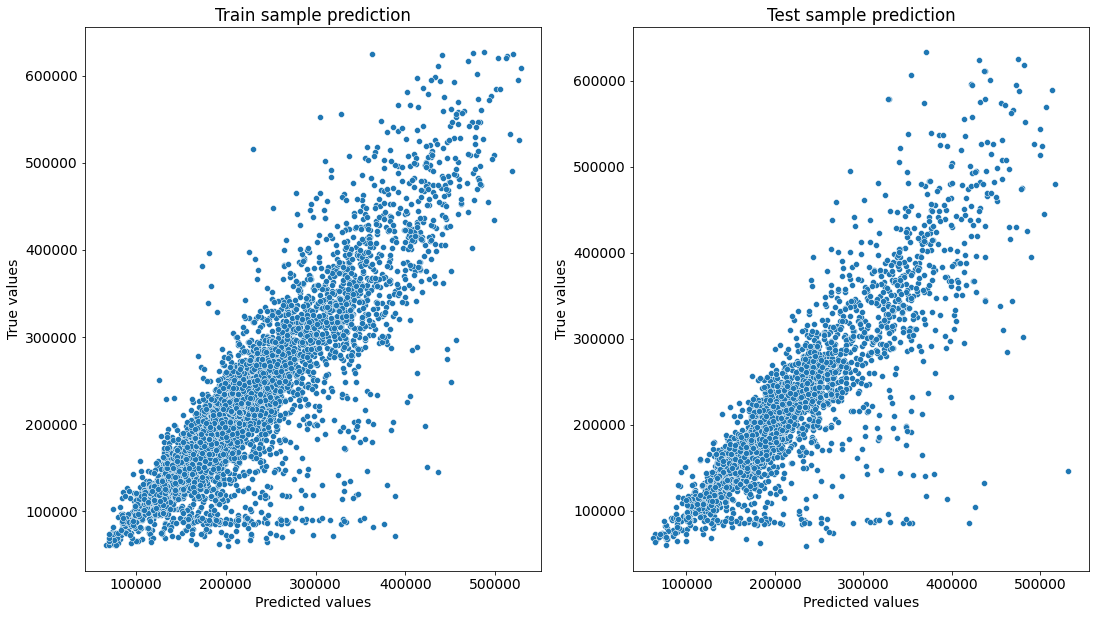

In [60]:
y_train_preds = br_model.predict(X_train)
y_valid_preds = br_model.predict(X_valid)

evaluate_preds(y_train, y_train_preds, y_valid, y_valid_preds)

#### Кросс-валидация

In [61]:
cv_score = cross_val_score(br_model, X_train, y_train, scoring='r2', cv=KFold(n_splits=3, shuffle=True, random_state=21))
cv_score

array([0.72832675, 0.70216129, 0.73004413])

In [62]:
cv_score.mean()

0.7201773857055077

### Прогнозирование на тестовом датасете

In [63]:
test_df.shape

(5000, 26)

In [64]:
test_df

,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Social_1,Social_2,Social_3,...,Rooms_outlier,HouseFloor_outlier,HouseYear_outlier,DistrictSize,new_district,IsDistrictLarge,MedPriceByRooms,MedPriceByFloorYear,MedPriceByShops,MedPriceBySocial
0,1.0,36.847630,19.094182,5.0,5.0,9.0,1970,24,4378,0,...,0,0,0,76.0,0,0,155971.002455,231699.201645,188965.010350,203058.075211
1,1.0,42.493907,32.493907,10.0,7.0,17.0,2017,2,629,1,...,0,0,0,164.0,0,1,155971.002455,231699.201645,166688.853748,167544.244106
2,2.0,59.463678,32.679351,9.0,19.0,19.0,1977,9,1892,0,...,0,0,0,580.0,0,1,209258.923960,231699.201645,188965.010350,119817.448457
3,3.0,49.646030,33.893825,6.0,2.0,2.0,1965,2,475,0,...,0,0,0,372.0,0,1,224242.564950,231699.201645,163101.726936,113093.786598
4,1.0,53.837056,32.679351,3.0,8.0,17.0,1977,35,7715,4,...,0,0,0,65.0,0,0,152150.570788,231699.201645,215544.689194,192570.557936
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,2.0,43.177521,30.339945,5.0,5.0,5.0,1962,31,6119,4,...,0,1,0,56.0,0,0,190153.608027,231699.201645,181193.401933,181947.371499
4996,3.0,93.698122,83.698122,10.0,21.0,27.0,2018,15,2787,2,...,0,0,0,26.0,0,0,367691.913179,231699.201645,239061.968552,258092.874069
4997,1.0,33.656723,19.003259,5.0,2.0,5.0,1966,28,6533,1,...,0,0,0,54.0,0,0,155971.002455,231699.201645,196083.195232,192768.430161
4998,1.0,38.635155,20.976257,9.0,8.0,14.0,1970,33,7976,5,...,0,0,0,40.0,0,0,155971.002455,231699.201645,245887.589856,217574.002517


In [65]:
submit = pd.read_csv('sample_submission.csv')
submit.head()

,Id,Price
0,4567,200000.0
1,5925,200000.0
2,960,200000.0
3,3848,200000.0
4,746,200000.0


In [66]:
predictions = br_model.predict(test_df) #stack.predict(test_df)
predictions

array([166018.13377448, 127496.05026504, 150585.07652009, ...,
       148950.06938989, 188939.50141398, 232488.78166483])

In [67]:
submit['Price'] = predictions
submit.head()

,Id,Price
0,4567,166018.133774
1,5925,127496.050265
2,960,150585.076520
3,3848,116141.228201
4,746,201261.505777


In [68]:
submit.to_csv('submit.csv', index=False)